In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np

import torch 
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
import random
import shutil
from copy import deepcopy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")



cpu


In [2]:
BASE_PATH = Path('/project/volume/data/out/KDEF-AKDEF/')
IMAGE_PATHS = list(BASE_PATH.rglob('*.jpg'))
LABELS = folders = [f.name for f in BASE_PATH.iterdir() if f.is_dir()]

TRAIN = 'train'
VAL = 'val'
TEST = 'test'

train_prop = 0.6
test_prop = 0.2
valid_prop = 0.2

number_of_images = len(list(BASE_PATH.rglob('*.jpg')))

n_train = int((number_of_images * train_prop) + 0.5)
n_valid = int((number_of_images * valid_prop) + 0.5)
n_test = number_of_images - n_train - n_valid

print(number_of_images)
print(f"[INFO] Number of images used in training ... {str(n_train)} ({str(train_prop * 100)}%)")
print(f"[INFO] Number of images used in validation ...{str(n_valid)} ({str(valid_prop * 100)}%)")
print(f"[INFO] Number of images used in testing ... {str(n_test)} ({str(test_prop * 100)}%)")

4898
[INFO] Number of images used in training ... 2939 (60.0%)
[INFO] Number of images used in validation ...980 (20.0%)
[INFO] Number of images used in testing ... 979 (20.0%)


In [118]:
def split_and_move():

    print(f"[INFO] Splitting files in train / test / val sets for each of {len(LABELS)} labels ...")

    for label in tqdm(LABELS):
        
        # create paths for each label
        folder_path = BASE_PATH / label
        train_destination = BASE_PATH / "train" / label
        val_destination = BASE_PATH / "val" / label
        test_destination = BASE_PATH / "test" / label

        # create the directories eg. "train / happy"
        train_destination.mkdir(parents=True, exist_ok=True)
        val_destination.mkdir(parents=True, exist_ok=True)
        test_destination.mkdir(parents=True, exist_ok=True)

        # get all the jpgs in the label file
        files = list(folder_path.rglob('*.jpg'))
        random.shuffle(files)

        train_n = (int((len(files) * train_prop) + 0.5))
        val_n = (int((len(files) * valid_prop) + 0.2))

        for file_idx, file in enumerate(files):
            if file_idx < train_n:
                shutil.move(str(file), train_destination)
            elif file_idx < train_n + val_n:
                shutil.move(str(file), val_destination)
            else:
                shutil.move(str(file), test_destination)

        if folder_path.exists() and folder_path.is_dir():
            shutil.rmtree(folder_path)

In [119]:
split_and_move()

  0%|                                                                                                                           | 0/7 [00:00<?, ?it/s]

Happy
Sad


 29%|████████████████████████████████▊                                                                                  | 2/7 [00:01<00:02,  1.78it/s]

Neutral


 43%|█████████████████████████████████████████████████▎                                                                 | 3/7 [00:03<00:04,  1.21s/it]

Angry


 57%|█████████████████████████████████████████████████████████████████▋                                                 | 4/7 [00:05<00:04,  1.51s/it]

Disgusted


 71%|██████████████████████████████████████████████████████████████████████████████████▏                                | 5/7 [00:06<00:03,  1.59s/it]

Surprised


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                | 6/7 [00:08<00:01,  1.55s/it]

Afraid


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]


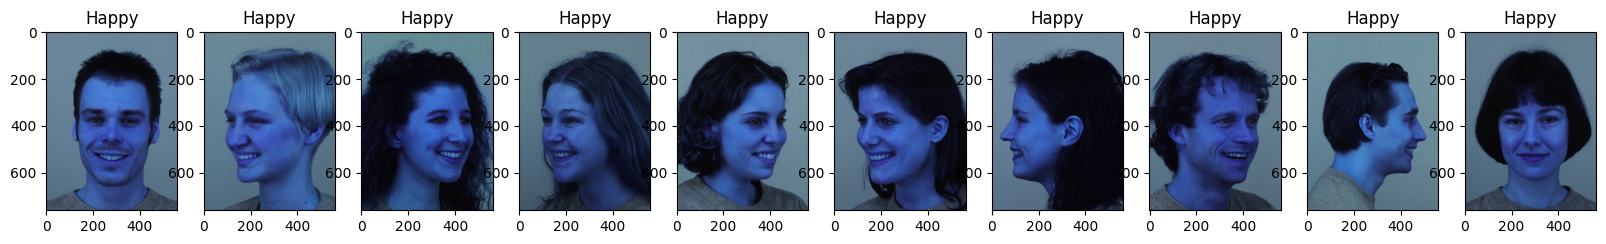

In [4]:
fig = plt.figure(figsize=(20,30))

for i in range(10):

    fig.add_subplot(1, 10, i + 1)
    img = cv2.imread(str(IMAGE_PATHS[i]))
    plt.imshow(np.array(img), cmap='gray')
    label = Path(IMAGE_PATHS[i]).parent.name
    plt.title(label)

plt.show()

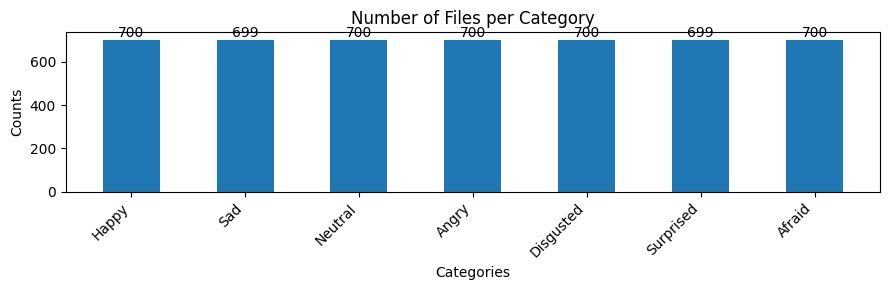

In [5]:
from collections import Counter
from pathlib import Path

def get_distribution():
    nbr_per_cat = Counter(Path(file).parent.name for file in IMAGE_PATHS)

    categories = list(nbr_per_cat.keys())
    counts = list(nbr_per_cat.values())

    plt.figure(figsize=(9, 3))
    bars = plt.bar(categories, counts, width=0.5)

    plt.xlabel('Categories')
    plt.ylabel('Counts')
    plt.title('Number of Files per Category')
    plt.xticks(rotation=45, ha='right')

    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), 
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

get_distribution()

In [5]:
data_transforms = {
    TRAIN: transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

In [6]:
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(BASE_PATH, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("[INFO] Loaded {} images under {}".format(dataset_sizes[x], x))
    
class_names = image_datasets[TRAIN].classes
print("[INFO] Classes: ", image_datasets[TRAIN].classes)

[INFO] Loaded 2938 images under train
[INFO] Loaded 980 images under val
[INFO] Loaded 980 images under test
[INFO] Classes:  ['Afraid', 'Angry', 'Disgusted', 'Happy', 'Neutral', 'Sad', 'Surprised']


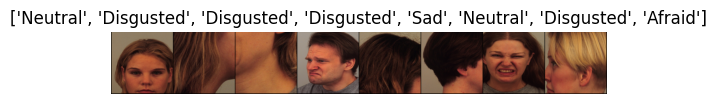

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [20]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training) # Revert model back to original training state

In [17]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[TEST]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.item()
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)


In [10]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16_bn()
vgg16.load_state_dict(torch.load('/project/volume/models/vgg16_bn.pth'))
print(vgg16.classifier[6].out_features) # 1000

1000


In [11]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

In [12]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [13]:
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] 
features.extend([nn.Linear(in_features=num_features, out_features=len(class_names))]) 
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [14]:
resume_training = False

if resume_training:
    print("Loading pretrained model..")
    vgg16.load_state_dict(torch.load('/project/volume/models/VGG16_kdef.pt'))
    print("Loaded!")


In [15]:
if use_gpu:
    vgg16.cuda()
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [18]:
import torch
print("Test before training")

with torch.no_grad():
    eval_model(vgg16, criterion) 

Test before training
Evaluating model
----------


Test batch 0/123

/tmp/ipykernel_841/3452285801.py:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)


Test batch 100/123
Evaluation completed in 17m 53s
Avg loss (test): 0.2459
Avg acc (test): 0.1500
----------


/tmp/ipykernel_841/642155024.py:17: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)


Ground truth:


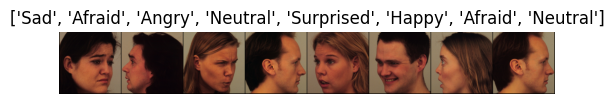

Prediction:


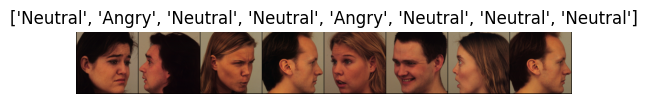

In [19]:
visualize_model(vgg16)

In [ ]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deep